## Skill Advisor model using Doc2Vec and K-mean clustering

In [1]:
import glob
import pandas as pd

# Read the cleaned json file generated from wordtovec notebook in dataframe

df = pd.read_json('wordtovec_cleaned.json', lines=True)

In [5]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Get the skills and corresponsing job titiles 
skill_list = df.skill.values.tolist()
job_label = df.job_name.values.tolist()

documents = [TaggedDocument(doc, [job_label[i]]) for i, doc in enumerate(skill_list)]


# make doc2vec model
model1 = Doc2Vec(documents, vector_size=50, window=3, min_count=2, 
                 workers=4, dbow_words=1, dm=0)
# train model
model1.train(documents=documents, total_examples=model1.corpus_count, epochs=50)

## PCA and t-SNE conversion

In [6]:
%%capture
# Load wordtovec notebook 
# Keep both notebooks in the same folder
from ipynb.fs.full.wordtovec import tsneconversion, cluster_visualization

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
    
    
df_tsne, Y = tsneconversion(model1, 'cook', ['data scientist', 'janitor', 'waiter'])



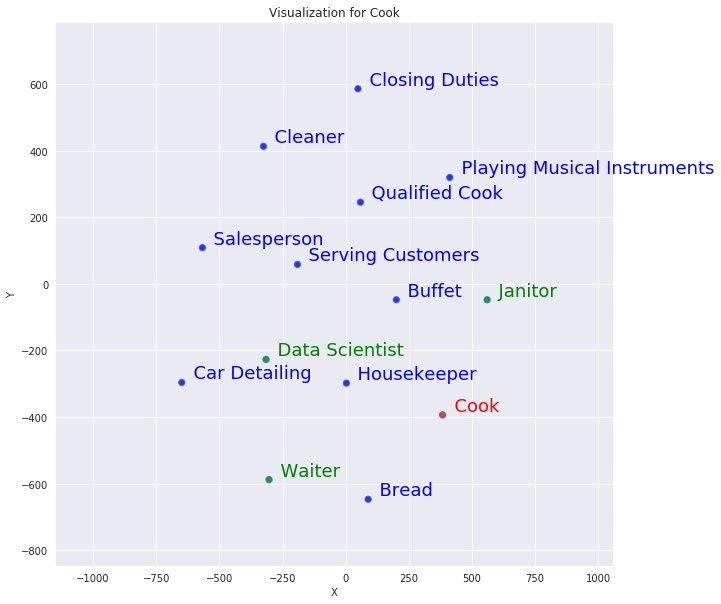

In [7]:
cluster_visualization(df_tsne, 'cook', Y, 500, 200)

In [13]:
model11l1.wv.most_similar('cook')

[('serving customers', 0.7365147471427917),
 ('playing musical instruments', 0.7218120694160461),
 ('closing duties', 0.7037789821624756),
 ('car detailing', 0.7026734352111816),
 ('buffet', 0.6953269243240356),
 ('bread', 0.6916913986206055),
 ('cleaner', 0.6891921758651733),
 ('salesperson', 0.6868873238563538),
 ('qualified cook', 0.6828380823135376),
 ('housekeeper', 0.6813172698020935)]

In [8]:
# Get job_title vectors

unique_jobs = set(job_label)
job_vectors = []
for job in unique_jobs:
    job_vectors.append(model1[job])
    

In [9]:
# Get skill Vectors

skill_vectors = []
for skill in model1.wv.vocab.keys():
    skill_vectors.append(model1.wv[skill])

In [10]:
# Combine all vectors 

import numpy as np

job_vectors = np.array(job_vectors)
skill_vectors = np.array(skill_vectors)
all_vec = np.concatenate((job_vectors, skill_vectors))
skills_and_jobs = list(unique_jobs) + list(model1.wv.vocab.keys())

In [11]:
# Run K-means

import nltk
from nltk.cluster import KMeansClusterer

NUM_CLUSTERS = 15
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=50)
assigned_clusters = kclusterer.cluster(all_vec, assign_clusters=True)

In [12]:
# For visualization

# Reduces the dimensionality from 300 to 50 dimensions with PCA
reduc = PCA(n_components=50).fit_transform(all_vec)
# Finds t-SNE coordinates for 2 dimensions
np.set_printoptions(suppress=True)

Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

In [17]:
# Create dataframe with skills and corresponding cluster number and TSNE co-ordinates

df_cluster = pd.DataFrame({'skill': skills_and_jobs, 'cluster': assigned_clusters, 
                           'X': Y[:,0], 'Y': Y[:,1]})

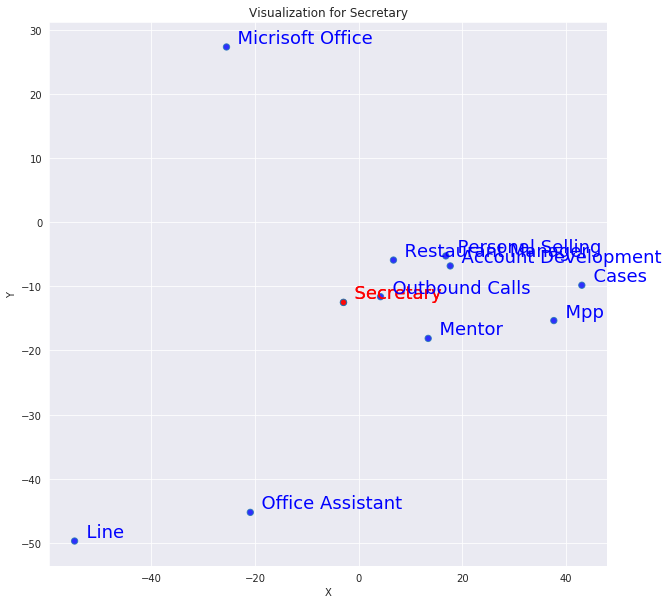

In [23]:
## CLuser plot for secretary
secretary = df_cluster[df_cluster.skill == 'secretary']
secretary.loc[:,"color"] = "red"
clust_number = secretary.cluster.values[0]
df_secretary = df_cluster[df_cluster.cluster == clust_number]

N_sample = 10
color = ["blue"] * N_sample
df_plot = df_secretary.sample(N_sample, random_state=30)
df_plot["color"] = color
df_plot = pd.concat([secretary, df_plot])
df_plot = df_plot.reset_index(drop=True)

cluster_visualization(df_plot, 'secretary', Y, 0, 0)